In [114]:
from sklearn.model_selection import train_test_split

In [25]:
import pyspark as ps    # for the pyspark suite
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('lecture')
         .getOrCreate()
        )
sc = spark.sparkContext

In [26]:
df = spark.read.csv('transactions.csv',
                    header=True,       # use headers or not
                    quote='"',         # char for quotes
                    sep=",",           # char for separation
                    inferSchema=True)  # do we infer schema or not ?

In [3]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- chain: integer (nullable = true)
 |-- dept: integer (nullable = true)
 |-- category: integer (nullable = true)
 |-- company: long (nullable = true)
 |-- brand: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- productsize: double (nullable = true)
 |-- productmeasure: string (nullable = true)
 |-- purchasequantity: integer (nullable = true)
 |-- purchaseamount: double (nullable = true)



In [4]:
df.show()

+-----+-----+----+--------+----------+-----+-------------------+-----------+--------------+----------------+--------------+
|   id|chain|dept|category|   company|brand|               date|productsize|productmeasure|purchasequantity|purchaseamount|
+-----+-----+----+--------+----------+-----+-------------------+-----------+--------------+----------------+--------------+
|86246|  205|   7|     707|1078778070|12564|2012-03-02 00:00:00|       12.0|            OZ|               1|          7.59|
|86246|  205|  63|    6319| 107654575|17876|2012-03-02 00:00:00|       64.0|            OZ|               1|          1.59|
|86246|  205|  97|    9753|1022027929|    0|2012-03-02 00:00:00|        1.0|            CT|               1|          5.99|
|86246|  205|  25|    2509| 107996777|31373|2012-03-02 00:00:00|       16.0|            OZ|               1|          1.99|
|86246|  205|  55|    5555| 107684070|32094|2012-03-02 00:00:00|       16.0|            OZ|               2|         10.38|
|86246| 

In [5]:
df.createOrReplaceTempView('trans')

In [6]:
query = """SELECT distinct id, 
                min(date) as first_purchase_date,
                max(date) as last_purchase_date,
                count(distinct date) as total_purchases,
                sum(purchasequantity) as total_purchase_quantity,
                sum(purchaseamount) as total_purchase_amount,
                SUM(CASE WHEN date >= '2012-09-02' THEN purchaseamount ELSE 0 END) AS last_3_months_spend
                FROM trans
                WHERE date <= '2012-12-01'
                GROUP BY id
             """
sdf = spark.sql(query)
# sdf.show()

In [7]:
rdf = sdf.toPandas()
rdf.to_csv("ndb1.csv")

In [8]:
query = """SELECT distinct id, 
                min(date) as first_purchase_date,
                max(date) as last_purchase_date,
                count(distinct date) as total_purchases,
                sum(purchasequantity) as total_purchase_quantity,
                sum(purchaseamount) as total_purchase_amount
                FROM trans
                WHERE date between '2012-12-02' and '2013-03-01'
                GROUP BY id
             """
sdf = spark.sql(query)
# sdf.show()

In [9]:
pdf = sdf.toPandas()
pdf.to_csv("ndb2_target.csv")

In [44]:
pdf = pd.read_csv("ndb2_target.csv", index_col=0)

In [30]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307323 entries, 0 to 307322
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       307323 non-null  int64  
 1   first_purchase_date      307323 non-null  object 
 2   last_purchase_date       307323 non-null  object 
 3   total_purchases          307323 non-null  int64  
 4   total_purchase_quantity  307323 non-null  int64  
 5   total_purchase_amount    307323 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 16.4+ MB


In [45]:
import pandas as pd
rdf = pd.read_csv("ndb1.csv",index_col=0)

In [234]:
pdf.head()

,id,first_purchase_date,last_purchase_date,total_purchases,total_purchase_quantity,total_purchase_amount
0,101266464,2012-12-15,2013-02-25,18,162,485.78
1,105318972,2012-12-02,2013-02-28,19,204,737.80
2,112987393,2013-01-04,2013-02-11,4,19,63.84
3,121094467,2012-12-06,2013-02-27,49,813,1688.14
4,124565931,2012-12-03,2013-02-28,52,399,1159.34


## Churn Prediction data

In [235]:
# Datebase for Churn prediction
fdf = pd.merge(rdf, pdf[["id","total_purchase_amount"]], how="left", left_on="id", right_on="id")
fdf.rename({"total_purchase_amount_y":"next_3_months_spend"}, axis=1, inplace=True)
fdf["churn"] = fdf["next_3_months_spend"].apply(lambda x:0 if x>0 else 1)


In [236]:
df_train, df_test= train_test_split(fdf, shuffle=True, test_size=0.2, random_state=42)
df_train.to_csv("fdb_churn_train.csv")
df_test.to_csv("fdb_churn_test.csv")

In [237]:
df_test["churn"].value_counts()

0    60271
1      182
Name: churn, dtype: int64

# RFM

In [19]:
pdf.head()

,id,first_purchase_date,last_purchase_date,total_purchases,total_purchase_quantity,total_purchase_amount
0,101266464,2012-12-15,2013-02-25,18,162,485.78
1,105318972,2012-12-02,2013-02-28,19,204,737.80
2,112987393,2013-01-04,2013-02-11,4,19,63.84
3,121094467,2012-12-06,2013-02-27,49,813,1688.14
4,124565931,2012-12-03,2013-02-28,52,399,1159.34


In [255]:
# Datebase for RFM prediction
# pdf["recency"] = pd.to_datetime("2013-03-02") - pd.to_datetime(pdf["last_purchase_date"]) 
pdf["recency"] = pd.to_datetime('2012-01-01') - pd.to_datetime(pdf["last_purchase_date"])
pdf["recency"] = pdf["recency"].apply(lambda x:x.days)
pdf.rename({"total_purchases" : "frequency", "total_purchase_amount" : "monetery"},
           axis = 1,
          inplace = True)

In [256]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(pdf['recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(pdf['frequency'], q=4, labels=f_labels)
# Create new columns R and F 
pdf = pdf.assign(R = r_groups.values, F = f_groups.values)
pdf.head()

ValueError: Bin edges must be unique: array([ 1.,  1.,  1.,  2., 42.]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [35]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(pdf['monetery'], q=4, labels=m_labels)
# Create new column M
pdf = pdf.assign(M = m_groups.values)

In [38]:
pdf.head()

,id,first_purchase_date,last_purchase_date,frequency,total_purchase_quantity,monetery,recency,R,F,M,RFM
0,101266464,2012-12-15,2013-02-25,18,162,485.78,5,3,3,2,3-3-2
1,105318972,2012-12-02,2013-02-28,19,204,737.80,2,4,3,2,4-3-2
2,112987393,2013-01-04,2013-02-11,4,19,63.84,19,1,1,1,1-1-1
3,121094467,2012-12-06,2013-02-27,49,813,1688.14,3,4,4,4,4-4-4
4,124565931,2012-12-03,2013-02-28,52,399,1159.34,2,4,4,3,4-4-3


In [37]:
pdf["RFM"] = pdf["R"].astype(str) + "-"  + pdf["F"].astype(str) + "-" + pdf["M"].astype(str)

In [39]:
rdf

,id,first_purchase_date,last_purchase_date,total_purchases,total_purchase_quantity,total_purchase_amount,last_3_months_spend
0,100787762,2012-03-08,2012-11-30,52,284,976.58,320.08
1,112364053,2012-03-09,2012-11-26,49,837,2462.90,401.42
2,112987393,2012-03-03,2012-10-05,27,252,594.15,32.08
3,121094467,2012-03-02,2012-11-29,163,2036,4997.94,1691.48
4,121473052,2012-03-07,2012-11-28,46,375,1510.74,568.64
...,...,...,...,...,...,...,...
302256,4395739747,2012-11-23,2012-11-23,1,4,39.96,39.96
302257,3831636404,2012-11-29,2012-11-29,1,9,27.09,27.09
302258,4381356327,2012-11-18,2012-11-25,3,93,377.07,377.07
302259,4358612016,2012-11-09,2012-11-09,1,20,114.30,114.30


In [40]:
# Datebase for RFM prediction
fdf = pd.merge(rdf, pdf[["id","RFM", "monetery"]], how="left", left_on="id", right_on="id")
fdf.rename({"monetery":"next_3_months_spend"}, axis=1, inplace=True)

fdf.to_csv("fdb_RFM.csv")

In [41]:
fdf

,id,first_purchase_date,last_purchase_date,total_purchases,total_purchase_quantity,total_purchase_amount,last_3_months_spend,RFM,next_3_months_spend
0,100787762,2012-03-08,2012-11-30,52,284,976.58,320.08,3-3-1,286.78
1,112364053,2012-03-09,2012-11-26,49,837,2462.90,401.42,1-3-3,910.43
2,112987393,2012-03-03,2012-10-05,27,252,594.15,32.08,1-1-1,63.84
3,121094467,2012-03-02,2012-11-29,163,2036,4997.94,1691.48,4-4-4,1688.14
4,121473052,2012-03-07,2012-11-28,46,375,1510.74,568.64,1-3-2,784.67
...,...,...,...,...,...,...,...,...,...
302256,4395739747,2012-11-23,2012-11-23,1,4,39.96,39.96,2-1-1,361.88
302257,3831636404,2012-11-29,2012-11-29,1,9,27.09,27.09,4-2-1,65.61
302258,4381356327,2012-11-18,2012-11-25,3,93,377.07,377.07,2-2-3,831.15
302259,4358612016,2012-11-09,2012-11-09,1,20,114.30,114.30,4-1-1,347.41


In [29]:
query = """SELECT distinct chain, 
                count(distinct id) as total_customer,
                sum(purchaseamount) as total_sales
                FROM trans
                GROUP BY chainrdf
             """
sdf = spark.sql(query)
sdf.show()
pdf = sdf.toPandas()
pdf.to_csv("chain_sales.csv")

+-----+--------------+--------------------+
|chain|total_customer|         total_sales|
+-----+--------------+--------------------+
|  392|           842|   662047.2899999995|
|   31|          3844| 4.148265802000082E7|
|   85|          3270| 1.322710844999991E7|
|   65|          2863|1.0672075089999927E7|
|  133|          1404|   6856905.029999938|
|  362|             6|   23723.09999999982|
|  108|           734|1.5753599110004539E7|
|  211|          2824|1.5119610379999874E7|
|  368|           248|  197487.05000000002|
|  101|         10177|  4.67795736399996E7|
|  126|          3579| 1.765192515999984E7|
|  115|            26|   92757.69999999921|
|   81|             4|   8793.690000000031|
|   26|          3647| 2.152529559999984E7|
|  384|           149|   639627.2499999984|
|  192|           195|   718639.1599999949|
|   12|          3218| 1.716450838999985E7|
|  388|            69|  62710.489999999976|
|  285|          3848|1.5786674109999878E7|
|  122|           124|   886830.

In [30]:
query = """SELECT distinct dept, 
                count(distinct id) as total_customer,
                sum(purchaseamount) as total_sales
                FROM trans
                GROUP BY dept
             """
sdf = spark.sql(query)
sdf.show()
pdf = sdf.toPandas()
pdf.to_csv("dept_sales.csv")

+----+--------------+--------------------+
|dept|total_customer|         total_sales|
+----+--------------+--------------------+
|  31|        259740|   8521662.690000013|
|  65|        117070|  1270338.8099999975|
|  53|        247967|       1.143394943E7|
|  78|         67971|  1007019.0699999981|
|  34|        254015|          9217318.09|
|  81|         87925|1.1167119810000002E7|
|  28|        240964|   7101620.030000004|
|  26|        305319| 7.453308867999949E7|
|  27|        199297|3.8713963619999975E7|
|  44|        198028|   6104942.410000011|
|  12|        205906|   6610733.090000004|
|  91|         57678|1.7518924749998093E7|
|  22|        235959|   8001726.500000006|
|  47|         66956|          1287244.36|
|   1|         57283|   9144412.490000008|
|  13|        179172|  2292008.3299999987|
|  16|        191503|  3214866.0200000047|
|   6|        184568|   9322618.460000005|
|   3|        247412|   9225715.230000013|
|  40|        183592|   4256262.110000006|
+----+-----

In [31]:
query = """SELECT distinct category, 
                count(distinct id) as total_customer,
                sum(purchaseamount) as total_sales
                FROM trans
                GROUP BY category
             """
sdf = spark.sql(query)
sdf.show()
pdf = sdf.toPandas()
pdf.to_csv("category_sales.csv")

+--------+--------------+------------------+
|category|total_customer|       total_sales|
+--------+--------------+------------------+
|    1829|         61921|1159417.3799999983|
|    7340|         19439| 247942.6999999998|
|    2122|          7171|108950.10999999994|
|    1721|         58878|476803.52000000025|
|    5614|        137060|3896432.4799999977|
|    8105|          2435|192728.59999999995|
|    1896|           925| 143061.2300000001|
|    2999|           179| 965.0000000000007|
|     516|        196992| 7322959.750000007|
|    5117|         90462| 2298661.120000002|
|    2711|          7018|138188.99999999997|
|    3704|         68551| 531449.9500000001|
|    9517|         99946| 954377.9599999978|
|     808|         42456|213318.20999999996|
|    2923|         82837|         864449.46|
|    2622|        226308| 4488733.760000003|
|    7324|         12459|104687.00000000007|
|    5907|        111753|1670618.8399999994|
|    2924|         71314| 703047.2599999998|
|    9206|

In [32]:
query = """SELECT distinct brand, 
                count(distinct id) as total_customer,
                sum(purchaseamount) as total_sales
                FROM trans
                GROUP BY brand
             """
sdf = spark.sql(query)
sdf.show()
pdf = sdf.toPandas()
pdf.to_csv("brand_sales.csv")

+-----+--------------+------------------+
|brand|total_customer|       total_sales|
+-----+--------------+------------------+
| 5518|         14374|210057.25999999983|
| 2142|         56876| 1140324.759999997|
|11748|         53968| 532573.8499999997|
| 5803|          4591| 79764.30999999998|
|18051|         45959|1130600.7999999975|
| 4935|          8761| 66596.52000000002|
|44358|         20725|          78172.27|
|11317|           810|          17156.46|
| 1959|          4437|159152.75000000003|
|31528|           160| 2284.499999999999|
|34759|          5071|109670.94000000002|
|68135|         15583|431460.47000000003|
|31367|          2091|14608.430000000006|
|27484|         14041|          62972.77|
|40653|           106| 6588.389999999994|
| 7833|          3827| 21375.76000000002|
| 1342|         12573|120289.16000000003|
|19530|         14052|136012.51999999996|
| 3997|           793| 4520.599999999998|
| 1580|          2481| 7419.509999999998|
+-----+--------------+------------

In [89]:
query = """SELECT distinct YEAR(date) as year,
                MONTH(date) as month, 
                count(distinct id) as total_customer,
                sum(purchaseamount) as total_sales
                FROM trans
                GROUP BY year,month
             """
sdf = spark.sql(query)
# sdf.show()
pdf = sdf.toPandas()
pdf.to_csv("month_sales.csv")

## RFM2


In [232]:
import pandas as pd
rdf = pd.read_csv("ndb1.csv",index_col=0)
pdf = pd.read_csv("ndb2_target.csv", index_col=0)

In [362]:
rdf = pd.read_csv("predictor.csv",index_col=0)
pdf = pd.read_csv("target.csv", index_col=0)

In [363]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3467 entries, 0 to 3466
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CustomerID             3467 non-null   float64
 1   first_purchase_date    3467 non-null   object 
 2   last_purchase_date     3467 non-null   object 
 3   total_purchases        3467 non-null   int64  
 4   total_purchase_amount  3467 non-null   float64
 5   last_3_months_spend    3467 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 189.6+ KB


In [364]:
# Datebase for RFM prediction
# pdf["recency"] = pd.to_datetime("2013-03-02") - pd.to_datetime(pdf["last_purchase_date"]) 
pdf["recency"] = pd.to_datetime('2012-01-01') - pd.to_datetime(pdf["last_purchase_date"])
pdf["recency"] = pdf["recency"].apply(lambda x:x.days)
pdf["monetery"] = pdf["total_purchase_amount"]/pdf["total_purchases"]
pdf.rename({"total_purchases" : "frequency"},
           axis = 1,
          inplace = True)

In [365]:
pdf[["recency",'frequency','monetery']].describe()

,recency,frequency,monetery
count,2620.000000,2620.000000,2620.000000
mean,48.021374,2.093893,391.189374
std,19.638065,2.107180,568.216199
min,23.000000,1.000000,-788.380000
25%,31.000000,1.000000,167.535000
50%,44.000000,1.000000,281.821250
75%,62.000000,2.000000,437.907500
max,93.000000,42.000000,12393.700000


In [366]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(2, 0, -1); f_labels = range(1, 3)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(pdf['recency'], [0,0.25,1], labels=r_labels, duplicates='drop')
# Assign these labels to 4 equal percentile groups y_test2
f_groups = pd.qcut(pdf['frequency'], [0,0.75,1], labels=f_labels, duplicates='drop')
# Create new columns R and F 
pdf = pdf.assign(R = r_groups.values, F = f_groups.values)

# Create labels for MonetaryValue
m_labels = range(1, 3)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(pdf['monetery'], [0,0.25,1], labels=m_labels, duplicates='drop')
# Create new column M
pdf = pdf.assign(M = m_groups.values)

In [367]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2620 entries, 0 to 2619
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   CustomerID             2620 non-null   float64 
 1   first_purchase_date    2620 non-null   object  
 2   last_purchase_date     2620 non-null   object  
 3   frequency              2620 non-null   int64   
 4   total_purchase_amount  2620 non-null   float64 
 5   recency                2620 non-null   int64   
 6   monetery               2620 non-null   float64 
 7   R                      2620 non-null   category
 8   F                      2620 non-null   category
 9   M                      2620 non-null   category
dtypes: category(3), float64(3), int64(2), object(2)
memory usage: 171.8+ KB


In [368]:
pdf["RFM"] = pdf["R"].astype(str) + "-"  + pdf["F"].astype(str) + "-" + pdf["M"].astype(str)

# Datebase for RFM prediction
# fdf = pd.merge(rdf, pdf[["id","RFM", "monetery"]], how="left", left_on="id", right_on="id")
fdf = pd.merge(rdf, pdf[["CustomerID","RFM","total_purchase_amount"]], how="left", left_on="CustomerID", right_on="CustomerID")

fdf.rename({"total_purchase_amount_y":"next_3_months_spend"}, axis=1, inplace=True)
fdf["RFM"] = fdf["RFM"].fillna("1-1-1")
fdf["next_3_months_spend"] = fdf["next_3_months_spend"].fillna(0)

df_train, df_test= train_test_split(fdf, shuffle=True, test_size=0.2, random_state=42)
df_train.to_csv("fdb_RFM3_train.csv")
df_test.to_csv("fdb_RFM3_test.csv")

In [369]:
fdf["RFM"].value_counts()

1-1-1    1910
1-1-2     774
2-2-2     277
1-2-2     188
2-1-2     165
2-1-1      56
1-2-1      50
2-2-1      47
Name: RFM, dtype: int64

In [370]:
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3467 entries, 0 to 3466
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerID               3467 non-null   float64
 1   first_purchase_date      3467 non-null   object 
 2   last_purchase_date       3467 non-null   object 
 3   total_purchases          3467 non-null   int64  
 4   total_purchase_amount_x  3467 non-null   float64
 5   last_3_months_spend      3467 non-null   float64
 6   RFM                      3467 non-null   object 
 7   next_3_months_spend      3467 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 243.8+ KB


In [371]:
df_train, df_test= train_test_split(fdf, shuffle=True, test_size=0.2, random_state=42)
df_train.to_csv("fdb_RFM3_train.csv")
df_test.to_csv("fdb_RFM3_test.csv")

-----

In [144]:
df1 = pd.read_csv("data.csv", encoding = "ISO-8859-1");df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [145]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [146]:
df1["InvoiceDate"] = df1["InvoiceDate"].apply(lambda x: pd.to_datetime(x.split(" ")[0]))

In [147]:
g = df1.groupby("InvoiceDate")

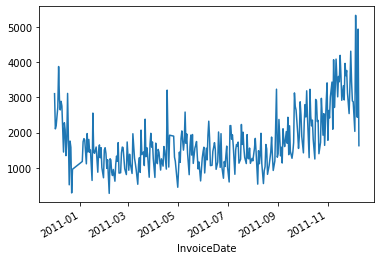

In [148]:
g.InvoiceNo.count().plot()

In [149]:
df1.dropna(inplace = True)

In [150]:
df1.to_csv("data2.csv")

In [329]:
df = spark.read.csv('data2.csv',
                    header=True,       # use headers or not
                    quote='"',         # char for quotes
                    sep=",",           # char for separation
                    inferSchema=True)  # do we infer schema or not ?

In [330]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [331]:
df.createOrReplaceTempView('trans')

In [354]:
query = """SELECT distinct CustomerID, 
                min(InvoiceDate) as first_purchase_date,
                max(InvoiceDate) as last_purchase_date,
                count(distinct InvoiceDate) as total_purchases,
                sum(Quantity * UnitPrice) as total_purchase_amount,
                SUM(CASE WHEN InvoiceDate > '2011-06-30' THEN Quantity * UnitPrice ELSE 0 END) AS last_3_months_spend
                FROM trans
                WHERE InvoiceDate between '2010-12-31' and '2011-10-01'
                GROUP BY CustomerID
             """
sdf = spark.sql(query)
sdf.show()

+----------+-------------------+-------------------+---------------+---------------------+-------------------+
|CustomerID|first_purchase_date| last_purchase_date|total_purchases|total_purchase_amount|last_3_months_spend|
+----------+-------------------+-------------------+---------------+---------------------+-------------------+
|   14024.0|2011-08-07 00:00:00|2011-08-10 00:00:00|              2|                327.7|              327.7|
|   13533.0|2011-03-17 00:00:00|2011-06-10 00:00:00|              2|               270.79|                0.0|
|   17633.0|2011-08-11 00:00:00|2011-09-29 00:00:00|              3|               1004.5|             1004.5|
|   17884.0|2011-02-01 00:00:00|2011-02-01 00:00:00|              1|   278.21999999999997|                0.0|
|   13094.0|2011-01-04 00:00:00|2011-09-20 00:00:00|             13|   1332.5400000000002|  681.6000000000001|
|   16629.0|2011-09-04 00:00:00|2011-09-27 00:00:00|              2|    417.7299999999999|  417.7299999999999|
|

In [355]:
rdf = sdf.toPandas()

In [356]:
pd.to_datetime(rdf.last_purchase_date).max()

Timestamp('2011-09-30 00:00:00')

In [357]:
pd.to_datetime(rdf.first_purchase_date).min()

Timestamp('2011-01-04 00:00:00')

In [358]:
rdf

,CustomerID,first_purchase_date,last_purchase_date,total_purchases,total_purchase_amount,last_3_months_spend
0,14024.0,2011-08-07,2011-08-10,2,327.70,327.70
1,13533.0,2011-03-17,2011-06-10,2,270.79,0.00
2,17633.0,2011-08-11,2011-09-29,3,1004.50,1004.50
3,17884.0,2011-02-01,2011-02-01,1,278.22,0.00
4,13094.0,2011-01-04,2011-09-20,13,1332.54,681.60
...,...,...,...,...,...,...
3462,13544.0,2011-04-13,2011-04-13,1,122.91,0.00
3463,15510.0,2011-01-13,2011-01-13,1,250.00,0.00
3464,16162.0,2011-04-01,2011-04-01,1,37.40,0.00
3465,14155.0,2011-03-18,2011-03-18,1,118.75,0.00


In [359]:
rdf = sdf.toPandas()
rdf.to_csv("predictor.csv")

In [340]:
query = """SELECT distinct CustomerID, 
                min(InvoiceDate) as first_purchase_date,
                max(InvoiceDate) as last_purchase_date,
                count(distinct InvoiceDate) as total_purchases,
                sum(Quantity * UnitPrice) as total_purchase_amount
                FROM trans
                WHERE InvoiceDate between '2011-09-30' and '2012-01-01'
                GROUP BY CustomerID
             """
sdf = spark.sql(query)
sdf.show()

+----------+-------------------+-------------------+---------------+---------------------+
|CustomerID|first_purchase_date| last_purchase_date|total_purchases|total_purchase_amount|
+----------+-------------------+-------------------+---------------+---------------------+
|   16561.0|2011-10-11 00:00:00|2011-12-04 00:00:00|              2|               511.12|
|   13956.0|2011-10-16 00:00:00|2011-12-04 00:00:00|              2|               346.15|
|   16596.0|2011-11-24 00:00:00|2011-11-24 00:00:00|              1|                129.5|
|   17633.0|2011-10-06 00:00:00|2011-11-08 00:00:00|              2|   305.34000000000003|
|   16916.0|2011-11-16 00:00:00|2011-11-16 00:00:00|              1|   378.17999999999995|
|   17884.0|2011-12-06 00:00:00|2011-12-06 00:00:00|              1|   114.61000000000001|
|   14768.0|2011-11-22 00:00:00|2011-11-22 00:00:00|              1|   59.400000000000006|
|   13918.0|2011-10-21 00:00:00|2011-10-21 00:00:00|              1|   1014.6399999999999|

In [341]:
pdf = sdf.toPandas()
pdf.to_csv("target.csv")

In [360]:
# Datebase for Churn prediction
fdf = pd.merge(rdf, pdf[["CustomerID","total_purchase_amount"]], how="left", left_on="CustomerID", right_on="CustomerID")
fdf.rename({"total_purchase_amount_y":"next_3_months_spend"}, axis=1, inplace=True)
fdf["churn"] = fdf["next_3_months_spend"].apply(lambda x:0 if x>0 else 1)

df_train, df_test= train_test_split(fdf, shuffle=True, test_size=0.2, random_state=42)
df_train.to_csv("fdb_churn_train.csv")
df_test.to_csv("fdb_churn_test.csv")

In [361]:
df_train.sum()

CustomerID                 4.230786e+07
total_purchases            1.001000e+04
total_purchase_amount_x    4.380732e+06
last_3_months_spend        1.775238e+06
next_3_months_spend        1.724410e+06
churn                      1.324000e+03
dtype: float64